## Setup

In [1]:
import matplotlib.pyplot as plt
from skimage.filters import *
import imutils
import cv2
import numpy as np
import pytesseract
from functools import reduce
from operator import add

## Import image

In [2]:
src = cv2.imread("./images/4.png")
src = cv2.cvtColor(src, cv2.COLOR_RGB2BGR)

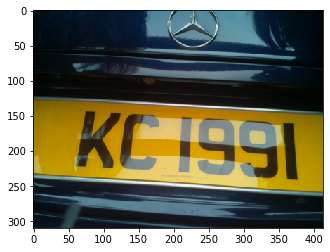

In [3]:
plt.imshow(src)
plt.show()

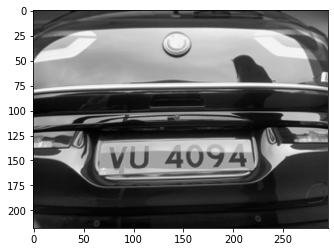

In [6]:
bw = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)
plt.imshow(bw, cmap = 'gray')
plt.show()

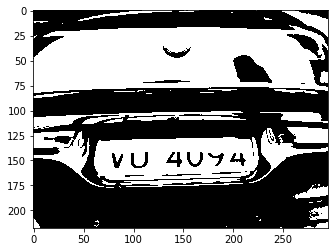

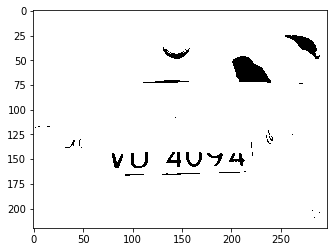

In [9]:
binary_image = cv2.adaptiveThreshold(bw, 1, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 201, 2)
binary_image_white_filled = cv2.copyMakeBorder(binary_image, 10, 10, 10, 10, cv2.BORDER_CONSTANT, value=[0, 0, 0])
mask = cv2.copyMakeBorder(binary_image_white_filled, 1, 1, 1, 1, cv2.BORDER_CONSTANT, 0)
cv2.floodFill(binary_image_white_filled, mask, (0, 0), 255, flags=cv2.FLOODFILL_MASK_ONLY)
binary_image_white_filled = mask[10: -10, 10: -10]
plt.imshow(binary_image, cmap = 'gray')
plt.show()
plt.imshow(binary_image_white_filled, cmap = 'gray')
plt.show()

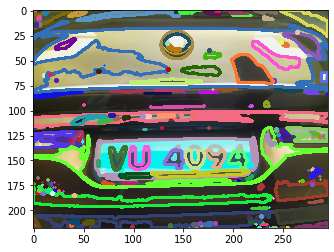

In [54]:
contours, hierarchy = cv2.findContours(binary_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
src_copy = src.copy()
for contour in contours:
    color = list(np.random.random(size=3) * 256)
    cv2.drawContours(src_copy, [contour], -1, color, 2)
plt.imshow(src_copy, cmap = 'gray')
plt.show()

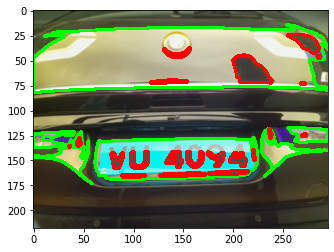

In [43]:
filtered_contours = {}
for i, h in enumerate(hierarchy[0]):
    if h[2] == -1 and h[3] != -1:
        parent_contour_index = h[3]
        child_contour = contours[i]
        if parent_contour_index in filtered_contours:
            filtered_contours[parent_contour_index].append(child_contour)
        else:
            filtered_contours[parent_contour_index] = [child_contour]

src_contour = src.copy()
parent_contours = [contours[i] for i in filtered_contours.keys()]
cv2.drawContours(src_contour, parent_contours, -1, (0,255,0), 2)
cv2.drawContours(src_contour, reduce(add, filtered_contours.values()), -1, (255,0,0), 2)
plt.imshow(src_contour, cmap = 'gray')
plt.show()

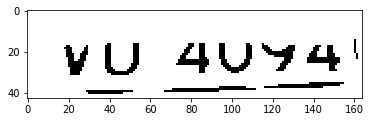

level	page_num	block_num	par_num	line_num	word_num	left	top	width	height	conf	text
1	1	0	0	0	0	0	0	164	43	-1	
2	1	1	0	0	0	18	14	144	27	-1	
3	1	1	1	0	0	18	14	144	27	-1	
4	1	1	1	1	0	18	14	144	27	-1	
5	1	1	1	1	1	18	14	144	27	0	VU4094


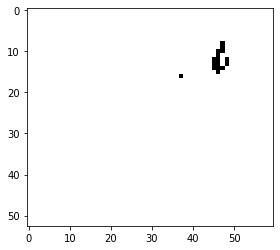

level	page_num	block_num	par_num	line_num	word_num	left	top	width	height	conf	text
1	1	0	0	0	0	0	0	60	53	-1


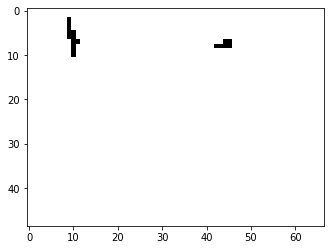

level	page_num	block_num	par_num	line_num	word_num	left	top	width	height	conf	text
1	1	0	0	0	0	0	0	67	49	-1	
2	1	1	0	0	0	9	2	37	9	-1	
3	1	1	1	0	0	9	2	37	9	-1	
4	1	1	1	1	0	9	2	37	9	-1	
5	1	1	1	1	1	42	7	4	2	2	SS


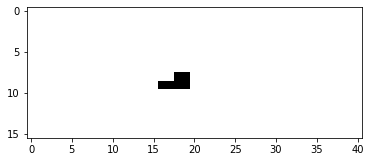

level	page_num	block_num	par_num	line_num	word_num	left	top	width	height	conf	text
1	1	0	0	0	0	0	0	41	16	-1


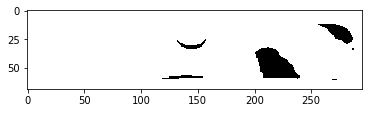

level	page_num	block_num	par_num	line_num	word_num	left	top	width	height	conf	text
1	1	0	0	0	0	0	0	295	69	-1	
2	1	1	0	0	0	119	12	169	49	-1	
3	1	1	1	0	0	132	12	156	23	-1	
4	1	1	1	1	0	132	12	156	23	-1	
5	1	1	1	1	1	132	25	26	9	0	S


In [44]:
for contour in parent_contours:
    x,y,w,h = cv2.boundingRect(contour)
    cropped_image = binary_image_white_filled[y:y+h, x:x+w]
    plt.imshow(cropped_image, cmap='gray')
    plt.show()
    print(pytesseract.image_to_data(cropped_image, lang='eng', config='--psm 6 -c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789'))